# Recommender System with Collaborative filtering algorithm (MovieLens 100k dataset)

MovieLens dataset - a classic dataset for training recommendation models. It can be obtained from the GroupLens website. There are various datasets, but the one that I will use below consists of 100,000 movie ratings by users (on a 1-5 scale). The main data file consists of a tab-separated list with user-id (starting at 1), item-id (starting at 1), rating, and timestamp as the four fields.

# I. Loading the dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
# for interactive inline plots
#%matplotlib notebook  
# for simple inline plots
%matplotlib inline 
import seaborn as sns
import time, math
#from IPython.display import display

In [3]:
# Loading ratings
names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=names)

# Loading movies info
item_info = pd.read_csv('ml-100k/u.item', sep='|', header=None, usecols=[1])   # Information about the items (keeps only movie's name)
item_info.columns = ['title']

# II. Descriptive analysis

In [4]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
ratings_df.shape

(100000, 4)

In [6]:
n_users = len(ratings_df['user_id'].unique())
n_items = len(ratings_df['item_id'].unique())
R_shape = (n_users, n_items)
print str(n_users) + ' users'
print str(n_items) + ' items'

943 users
1682 items


943 users gave ratings to 1682 movies. There are 100,000 ratings in total.

In [11]:
ratings_df['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

The average rating is 3.52 on a scale from 1.0 to 5.0, with a standard deviation of 1.12. The median rating is 4.0.

##### Visualizing ratings distribution

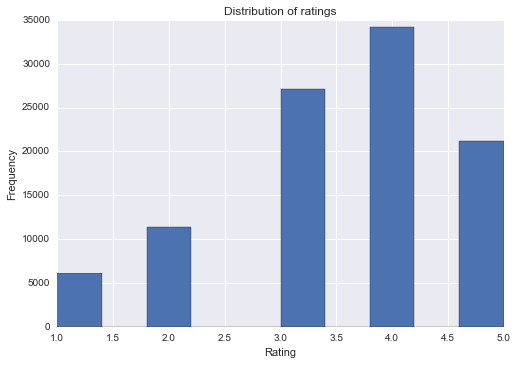

In [78]:
ratings_df['rating'].hist(grid=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')

##### Visualizing ratings after normalization

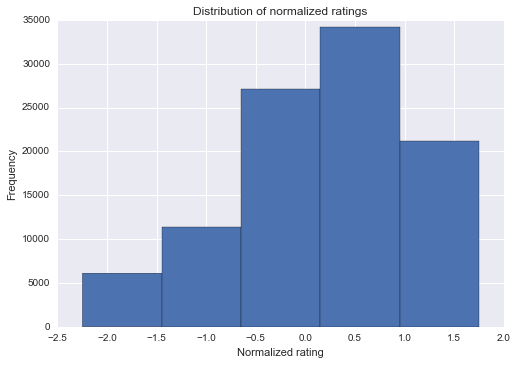

In [90]:
from sklearn.preprocessing import scale
binwidth = 0.8
data = scale(ratings_df['rating'].astype(float))
plt.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth))    # Z-score normalization
plt.xlabel('Normalized rating')
plt.ylabel('Frequency')
plt.title('Distribution of normalized ratings')

##### How many movies did people rate on average?

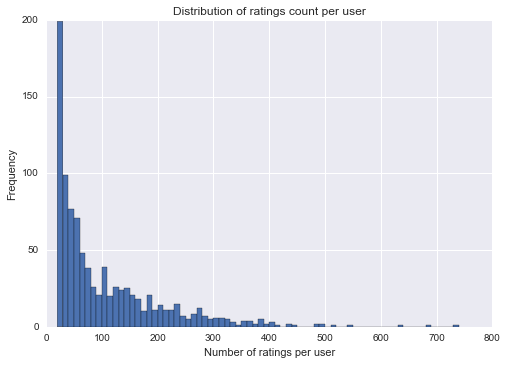

In [75]:
df = pd.DataFrame(R).replace('0', np.nan).count(axis=1)  # count number of ratings per user
binwidth = 10
df.hist(bins=np.arange(min(df), max(df) + binwidth, binwidth))    
plt.xlabel('Number of ratings per user')
plt.ylabel('Frequency')
plt.title('Distribution of ratings count per user')

It appears that most of users rated less than 50 movies.

##### What is the mean rating of each movie?

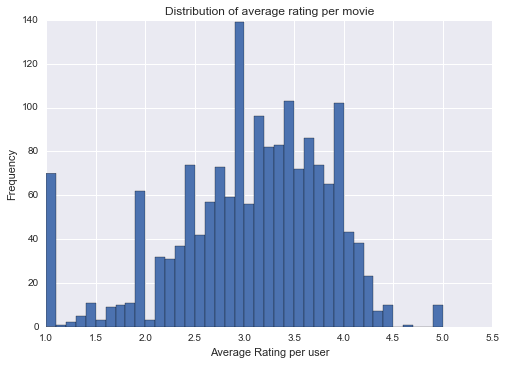

In [87]:
df = pd.DataFrame(R).replace('0', np.nan).mean(axis=0)   # average of ratings per movie
binwidth = .1
df.hist(bins=np.arange(min(df), max(df) + binwidth, binwidth))    
plt.xlabel('Average Rating per user')
plt.ylabel('Frequency')
plt.title('Distribution of average rating per movie')

The spike on '1' suggests that this could also be intepreted as binary rating.  
In other words, some people don't want to see certain movies at all. Same on 5 and on 3.

##### Movie titles

Showing movies title:

In [25]:
item_info.head()

,title
0,Toy Story (1995)
1,GoldenEye (1995)
2,Four Rooms (1995)
3,Get Shorty (1995)
4,Copycat (1995)


##### Defining X and y

We can define a predictor X and a target variable y:

In [9]:
X = ratings_df[['user_id', 'item_id']].values
y = ratings_df['rating'].values

print 'X'
print X
print 'y'
print y

X
[[ 196  242]
 [ 186  302]
 [  22  377]
 ..., 
 [ 276 1090]
 [  13  225]
 [  12  203]]
y
[3 3 1 ..., 1 2 3]


##### Defining a Rating matrix R

Most recommendation models consist of building a user-by-item matrix with some sort of "interaction" number in each cell. Here, users give items numerical ratings, this is called an explicit feedback model. We can build a user-item (or rating) matrix as follows:

| R           | Item #1           | ...  |  Item #n | 
| --- |  :---:  :---:       | :---: |
| User #1      |  ... | ...  | ... |
| ...      | ... |      ...      |   ... |
| User #m | ... | ...     |  ... |

In [91]:
from scipy import sparse

def ConvertToDense(X, y, shape):  # from R=(X,y), in sparse format 
    row  = X[:,0]
    col  = X[:,1]
    data = y
    matrix_sparse = sparse.csr_matrix((data,(row,col)), shape=(shape[0]+1,shape[1]+1))  # sparse matrix in compressed format (CSR)
    R = matrix_sparse.todense()   # convert sparse matrix to dense matrix, same as: matrix_sparse.A
    R = R[1:,1:]                  # removing the "Python starts at 0" offset
    R = np.asarray(R)             # convert matrix object to ndarray object
    return R
  
n_users = len(ratings_df['user_id'].unique())
n_items = len(ratings_df['item_id'].unique())
R_shape = (n_users, n_items)

R = ConvertToDense(X, y, R_shape)
print R
print R.shape

[[5 3 4 ..., 0 0 0]
 [4 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [5 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 5 0 ..., 0 0 0]]
(943L, 1682L)


In [92]:
print R[1,0]

4


As expected, the rating of movie #1 from user #2 is 4. (Note that the index is shifted by 1)

##### Computing the sparsity of R

In [93]:
print len(R.nonzero()[0]) / float(R.shape[0] * R.shape[1])

0.0630466936422


Sparsity is 6.3%. This means that 6.3% of the user-item ratings have a value. **Note that, although we filled in missing ratings as 0, we should not assume these values to truly be zero. They are just empty entries. As mentioned earlier, ratings are defined from 1 to 5.**

# III. Model-based Collaborative Filtering (Matrix Factorization approach)

In the Matrix Factorization approach, the idea is to find 2 matrices X and $\Theta$ such as R ~ X . $\Theta$.T.  
X contains the features of the items. $\Theta$ contains the features of the users. The idea is to learn latent factors of users (Theta) and latent factors of items (X), so the product of the two can fit the know data.  
Matrix factorization algorithm can use stochastic gradient descent algorithm: One way to approach this problem is the first intialize the two matrices with some values, calculate how 'different' their product is to *R*, and then try to minimize this difference iteratively. The gradient descent algorithm aims at finding a local minimum of the difference.  

In this example, we will use Non-Negative Matrix Factorization approach, available in the scikit-learn package.

## 1. Non-Negative Matrix Factorization (NMF, scikit-learn package)

Find two non-negative matrices (W, H) whose product approximates the non-negative matrix R.   
NOTE: since the values of matrix R MUST be all positive, we CAN'T do mean-centering normalization here (although this would improve the accuracy).

In [94]:
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=20)     # starts with 20 latents factors

# Matrix factorization               # V ~ W.H  (Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. )
nmf_model.fit(R)                     # R can be array-like or sparse, here it is array-like (dense)
Theta = nmf_model.transform(R)       # user latent factors (= W, called the features matrix)
M = nmf_model.components_.T          # item latent factors (= H.T) (H is called the coefficient matrix)

# Making the predictions
R_pred = M.dot(Theta.T)              # See http://stackoverflow.com/questions/24739121/nonnegative-matrix-factorization-in-sklearn
R_pred = R_pred.T                    # same dimensions as R

print 'Item features - M:', M.shape
print 'User features - Theta:', Theta.shape
print
print 'R ~ M * Theta.T:'
print R_pred.round(2)
print R_pred.shape

Item features - M: (1682L, 20L)
User features - Theta: (943L, 20L)

R ~ M * Theta.T:
[[ 4.38  2.1   1.3  ...,  0.    0.04  0.05]
 [ 2.35  0.03  0.02 ...,  0.02  0.    0.  ]
 [ 0.23  0.    0.11 ...,  0.02  0.    0.  ]
 ..., 
 [ 1.85  0.05  0.39 ...,  0.    0.    0.  ]
 [ 1.44  0.03  0.   ...,  0.02  0.    0.  ]
 [ 1.32  2.24  1.18 ...,  0.    0.04  0.03]]
(943L, 1682L)


## 2. Hyperparameter tuning with NMF

### 2.1 Load the data set

In [95]:
def GetShape(filename):
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(filename, sep='\t', names=names)
    n_users = len(df['user_id'].unique())
    n_items = len(df['item_id'].unique())
    return (n_users, n_items)

def LoadData(filename, R_shape):
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(filename, sep='\t', names=names)   
    X = df[['user_id', 'item_id']].values
    y = df['rating'].values   
    return X, y, ConvertToDense(X, y, R_shape)
 
R_shape = GetShape('ml-100k/u.data') 
X, y, R = LoadData('ml-100k/u.data', R_shape)     

### 2.2 Split into training and test set

In [96]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

R_train = ConvertToDense(X_train, y_train, R_shape)
R_test = ConvertToDense(X_test, y_test, R_shape)

print 'R_train'
print R_train
print R_train.shape
print
print 'R_test'
print R_test
print R_test.shape

R_train
[[0 3 4 ..., 0 0 0]
 [4 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
(943L, 1682L)

R_test
[[5 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [5 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 5 0 ..., 0 0 0]]
(943L, 1682L)


### 2.3 Choose a model: NMF

In [85]:
from sklearn.decomposition import NMF

parametersNMF = {
                    'n_components' : 20,     # number of latent factors
                    'init' : 'random', 
                    'random_state' : 0, 
                    'alpha' : 0.01,          # regularization term
                    'l1_ratio' : 0,          # set regularization = L2 
                    'max_iter' : 15
                }

estimator = NMF(**parametersNMF)

##### Estimating the error (RMSE) before tuning the hyperparameters

In [97]:
from sklearn.metrics import mean_squared_error

def get_rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()     # Ignore nonzero terms
    actual = actual[actual.nonzero()].flatten() # Ignore nonzero terms
    return np.sqrt(mean_squared_error(pred, actual))

In [87]:
err = 0
n_iter = 0.
n_folds = 5
for train_index, test_index in KFold(X.shape[0], n_folds=5):   
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Converting sparse array to dense array
    R_train = ConvertToDense(X_train, y_train, R_shape)
    R_test = ConvertToDense(X_test, y_test, R_shape)

    # Training (matrix factorization)
    t0 = time.time()
    estimator.fit(R_train)  
    Theta = estimator.transform(R_train)       # user features
    M = estimator.components_.T                # item features
    print "Fit in %0.3fs" % (time.time() - t0)
    n_iter += estimator.n_iter_ 

    # Making the predictions
    R_pred = M.dot(Theta.T)
    R_pred = R_pred.T      
    
    # Clipping values                                                    
    R_pred[R_pred > 5] = 5.           # clips ratings above 5             
    R_pred[R_pred < 1] = 1.           # clips ratings below 1

    # Computing the error on the validation set 
    err += get_rmse(R_pred, R_test)
    print get_rmse(R_pred, R_test)
    
print "*** RMSE Error : ", err / n_folds
print "Mean number of iterations:", n_iter / n_folds

Fit in 0.549s
2.55719035198
Fit in 0.532s
2.46203612291
Fit in 0.517s
2.42462591174
Fit in 0.531s
2.4267105088
Fit in 0.717s
2.47350616522
*** RMSE Error :  2.46881381213
Mean number of iterations: 13.6


### 2.4 Choose cross validation iterator

In [98]:
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.33, random_state=0)        # 5-fold scheme

### 2.5 Grid Search

In [386]:
param =        {
                    'n_components' : [15, 20, 25],
                    'alpha' : [0.001, 0.01, 0.1],
                    'l1_ratio' : [0], 
                    'max_iter' : [15, 20, 25]
                }

# Keep track of RMSE and parameters
grid_search = pd.DataFrame([[0, 0, 0, 0, 0]])
grid_search.columns = ['n_components', 'alpha', 'l1_ratio', 'max_iter'] + ['RMSE']

# nb of folds in ShuffleSplit CV
n_folds = 5      
i = 0

# Performing the Grid search
for n_components in param['n_components']:
    for alpha in param['alpha']:
        for l1_ratio in param['l1_ratio']:
            for max_iter in param['max_iter']:

                err = 0
                n_iter = 0
                print 'Search', i, '/', 3 ** 3 - 1
                for train_index, test_index in cv:
    
                    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
                    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    
                    # Converting sparse array to dense array
                    R_train = ConvertToDense(X_train_cv, y_train_cv, R_shape)
                    R_test = ConvertToDense(X_test_cv, y_test_cv, R_shape)

                    # updating the parameters
                    parametersNMF = {
                    'n_components' : n_components,
                    'init' : 'random', 
                    'random_state' : 0, 
                    'alpha' : alpha,
                    'l1_ratio' : l1_ratio,
                    'max_iter' : max_iter}
                    estimator = NMF(**parametersNMF)
                
                    # Training (matrix factorization)
                    t0 = time.time()
                    estimator.fit(R_train)  
                    Theta = estimator.transform(R_train)       # user features
                    M = estimator.components_.T                # item features
                    #print "Fit in %0.3fs" % (time.time() - t0)
                    n_iter += estimator.n_iter_ 

                    # Making the predictions
                    R_pred = M.dot(Theta.T).T
                    
                    # Clipping values                                                    
                    R_pred[R_pred > 5] = 5.           # clips ratings above 5             
                    R_pred[R_pred < 1] = 1.           # clips ratings below 1

                    # Computing the error on the validation set 
                    err += get_rmse(R_pred, R_test)
    
                #print "RMSE Error : ", err / n_folds
                grid_search.loc[i] = [n_components, alpha, l1_ratio, max_iter, err / n_folds]
                print grid_search.loc[i].tolist(), "Mean number of iterations:", n_iter / n_folds
                i += 1

best_params = grid_search.sort_values('RMSE')[:1]
print '*** best params ***'
print best_params

Search 0 / 26
[15.0, 0.001, 0.0, 10.0, 2.630870701832047] Mean number of iterations: 9
Search 1 / 26
[15.0, 0.001, 0.0, 15.0, 2.6293345483256489] Mean number of iterations: 10
Search 2 / 26
[15.0, 0.001, 0.0, 20.0, 2.6284694197417253] Mean number of iterations: 10
Search 3 / 26
[15.0, 0.01, 0.0, 10.0, 2.6308881823876371] Mean number of iterations: 9
Search 4 / 26
[15.0, 0.01, 0.0, 15.0, 2.6293477517784618] Mean number of iterations: 10
Search 5 / 26
[15.0, 0.01, 0.0, 20.0, 2.6284767438994909] Mean number of iterations: 10
Search 6 / 26
[15.0, 0.10000000000000001, 0.0, 10.0, 2.6310681703949577] Mean number of iterations: 9
Search 7 / 26
[15.0, 0.10000000000000001, 0.0, 15.0, 2.6294794987448191] Mean number of iterations: 10
Search 8 / 26
[15.0, 0.10000000000000001, 0.0, 20.0, 2.6285464641339007] Mean number of iterations: 10
Search 9 / 26
[20.0, 0.001, 0.0, 10.0, 2.6365694085242573] Mean number of iterations: 9
Search 10 / 26
[20.0, 0.001, 0.0, 15.0, 2.6382140954909525] Mean number of i

In [99]:
parametersNMF_opt = {
                    'n_components' : 20,     # number of latent factors
                    'init' : 'random', 
                    'random_state' : 0, 
                    'alpha' : 0.01,          # regularization term
                    'l1_ratio' : 0,          # set regularization = L2 
                    'max_iter' : 15
                }

### 2.6 Final evaluation on the test set

In [21]:
estimator = NMF(**parametersNMF_opt)
                
# Training (matrix factorization)
estimator.fit(R_train)  
Theta = estimator.transform(R_train)       # user features
M = estimator.components_.T                # item features

# Making the predictions
R_pred = M.dot(Theta.T).T
                    
# Clipping values                                                    
R_pred[R_pred > 5] = 5.           # clips ratings above 5             
R_pred[R_pred < 1] = 1.           # clips ratings below 1

# Computing the error on the test set 
print 'RMSE test:', get_rmse(R_pred, R_test)

RMSE test: 2.47350616522


### 2.7 Train the final model on whole dataset

In [22]:
estimator = NMF(**parametersNMF_opt)
                
# Training (matrix factorization)
estimator.fit(R)  
Theta = estimator.transform(R)            # user features
M = estimator.components_.T               # item features

# Making the predictions
R_pred = M.dot(Theta.T).T
                    
# Clipping values                                                    
R_pred[R_pred > 5] = 5.           # clips ratings above 5             
R_pred[R_pred < 1] = 1.           # clips ratings below 1

#### When the predictive model is satisfying, save it to a file¶

In [ ]:
import cPickle

# Save the trained model to file
with open('fittedmodel.cpickle', 'wb') as f:
    cPickle.dump(estimator, f)

# Load a previously Fitted Regressor....
#with open('fittedmodel.cpickle', 'rb') as f:          
#    estimator = cPickle.load(f)    
    ## ...and merge with a presently Fitted Regressor
    ##if MergeImportedWithCurrentTrainedModel == True:
        #estimator = estimator.fit(X_train, y_train)    

## 3. Making item (movie) recommendations

### 3.1 Item recommendation for an active user (given its rating history)

Here the recommandations are based on the prediction of the model with the lowest RMSE

In [26]:
def make_recommendation_activeuser(R, prediction, user_idx, k=5):
    '''
    user_idx ...... select an active user
    k  ............ number of movies to recommend
    '''
    rated_items_df_user = pd.DataFrame(R).iloc[user_idx, :]                 # get the list of actual ratings of user_idx (seen movies)
    user_prediction_df_user = pd.DataFrame(prediction).iloc[user_idx,:]     # get the list of predicted ratings of user_idx (unseen movies)
    reco_df = pd.concat([rated_items_df_user, user_prediction_df_user, item_info], axis=1)   # merge both lists with the movie's title
    reco_df.columns = ['rating','prediction','title']

    print 'Preferred movies for user #', user_idx
    print reco_df.sort_values(by='rating', ascending=False)[:k]             # returns the 5 seen movies with the best actual ratings
    print 'Recommended movies for user #', user_idx
    reco_df = reco_df[ reco_df['rating'] == 0 ]
    print reco_df.sort_values(by='prediction', ascending=False)[:k]         # returns the 5 unseen movies with the best predicted ratings
    print
    print

make_recommendation_activeuser(R, R_pred, user_idx=50, k=5)
make_recommendation_activeuser(R, R_pred, user_idx=130, k=5)

Preferred movies for user # 50
     rating  prediction                            title
171       5    2.145675  Empire Strikes Back, The (1980)
180       5    2.168630        Return of the Jedi (1983)
172       5    1.333595       Princess Bride, The (1987)
49        5    2.814568                 Star Wars (1977)
143       5    1.129017                  Die Hard (1988)
Recommended movies for user # 50
     rating  prediction                              title
173       0    2.269292     Raiders of the Lost Ark (1981)
95        0    1.664405  Terminator 2: Judgment Day (1991)
194       0    1.603940             Terminator, The (1984)
78        0    1.557191               Fugitive, The (1993)
182       0    1.342882                       Alien (1979)


Preferred movies for user # 130
     rating  prediction                        title
285       5    2.613741  English Patient, The (1996)
312       5    2.006553               Titanic (1997)
535       5    1.000000               Ponette (

### 3.2 Item recommendation for a new user (wih rating history)

In [ ]:
# creating a new user profile:
my_ratings = np.zeros((1682,1), dtype=int)
my_ratings[0] = 4 
my_ratings[1] = 4 
my_ratings[10] = 1 
my_ratings[15] = 3
my_ratings[27] = 4
my_ratings[34] = 1
my_ratings[49] = 1
my_ratings[55] = 1
my_ratings[61] = 1
my_ratings[68] = 5
my_ratings[70] = 4
my_ratings[81] = 4
my_ratings[87] = 2
my_ratings[94] = 4
my_ratings[120] = 2
my_ratings[171] = 1
my_ratings[173] = 4
my_ratings[175] = 1
my_ratings[182] = 1
my_ratings[194] = 2
my_ratings[203] = 5
my_ratings[209] = 5
my_ratings[221] = 1
my_ratings[234] = 2
my_ratings[312] = 3
my_ratings[317] = 3
my_ratings[322] = 3
my_ratings[342] = 1
my_ratings[378] = 1
my_ratings[379] = 1
my_ratings[392] = 3
my_ratings[404] = 2
my_ratings[422] = 4
my_ratings[542] = 4

for i in range(len(my_ratings)):
    print i, my_ratings[i], item_info.iloc[i]['title']

In [28]:
# Adding a new user to the R matrix 
newR = np.concatenate((R, my_ratings.T))

# Recompute the Matrix factorization
newTheta = estimator.fit_transform(newR)  
newX = estimator.components_.T       

# Making the predictions
newR_pred = newX.dot(newTheta.T).T

# clipping values                                                    
newR_pred[newR_pred > R.max()] = R.max()           # clips ratings above 5             
newR_pred[newR_pred < R.min() + 1] = R.min() +1    # clips ratings below 1

# Making the recommendation
make_recommendation_activeuser(newR, newR_pred, user_idx=newR.shape[0]-1, k=10)

Preferred movies for user # 943
     rating  prediction                                      title
209       5    1.361019  Indiana Jones and the Last Crusade (1989)
203       5    1.203155                  Back to the Future (1985)
68        5    1.271018                        Forrest Gump (1994)
0         4    1.540865                           Toy Story (1995)
422       4    1.345897          E.T. the Extra-Terrestrial (1982)
1         4    1.000000                           GoldenEye (1995)
70        4    1.693975                      Lion King, The (1994)
81        4    1.456354                       Jurassic Park (1993)
94        4    1.617104                             Aladdin (1992)
542       4    1.000000                     Mis�rables, Les (1995)
Recommended movies for user # 943
     rating  prediction                                   title
587       0    1.747441             Beauty and the Beast (1991)
180       0    1.545142               Return of the Jedi (1983)
78   

### 3.3 Item recommendation for a new user (wihout rating history)

In [30]:
def make_recommendation_newuser(item_sim, item_idx, k=5):
    '''
    item_idx ...... select an item
    k  ............ number of movies to recommend
    '''
    reco_item_df = pd.DataFrame(item_sim).iloc[item_idx, :] 
    reco_item_df = pd.concat([reco_item_df, item_info], axis=1)   # merge list with the movie's title
    reco_item_df.columns = ['similarity','title']
    reco_item_df = reco_item_df.sort_values(by='similarity',ascending=False)

    print 'Recommended movies for a new user (without rating history), currently looking at movie:', reco_item_df.iloc[0]['title']
    print reco_item_df[1:k+1]           # returns the 5 movies the most similar to item_idx
    print

from sklearn.metrics.pairwise import cosine_similarity
item_sim = cosine_similarity(M)                      # Use item features matrix to compute movie-to-movie similarity matrices
make_recommendation_newuser(item_sim, item_idx=1, k=5)
make_recommendation_newuser(item_sim, item_idx=20, k=5)
make_recommendation_newuser(item_sim, item_idx=500, k=5)

Recommended movies for a new user (without rating history), currently looking at movie: GoldenEye (1995)
      similarity                              title
232     0.993000                 Under Siege (1992)
549     0.973123  Die Hard: With a Vengeance (1995)
67      0.970855                   Crow, The (1994)
28      0.969772              Batman Forever (1995)
1187    0.968191               Young Guns II (1990)

Recommended movies for a new user (without rating history), currently looking at movie: Muppet Treasure Island (1996)
     similarity                                         title
472    0.869733              James and the Giant Peach (1996)
476    0.804469                                Matilda (1996)
102    0.774011                All Dogs Go to Heaven 2 (1996)
150    0.763532  Willy Wonka and the Chocolate Factory (1971)
595    0.760037           Hunchback of Notre Dame, The (1996)

Recommended movies for a new user (without rating history), currently looking at movie: Dum